In [1020]:
import random
import chess
import chess.svg

from abc import abstractmethod

In [1021]:
class Player():

    def __init__(self, board: chess.Board, color: chess.Color):
        self._board = board
        self._color = color

    @abstractmethod
    def choose_move(self) -> str:
        pass

    def get_game(self):
        return self._board
    
    @property
    def color(self):
        return self._color

class RandomPlayer(Player):

    def __init__(self, board: chess.Board, color: chess.Color): 
        super().__init__(board, color)
    
    def choose_move(self) -> chess.Move:
        moves = list(self._board.legal_moves)
        return random.choice(moves)

class DumbCapturePlayer(Player):

    def __init__(self, board: chess.Board, color: chess.Color): 
        super().__init__(board, color)
    
    def choose_move(self) -> chess.Move:
        moves = list(self._board.legal_moves)

        checking = list(m for m in moves if self._board.gives_check(m))
        if len(checking) > 0:
            return random.choice(checking)
        
        captures = list(m for m in moves if self._board.is_capture(m))
        if len(captures) > 0:
            return random.choice(captures)
        
        return random.choice(moves)

class BoardEvaluator():

    piece_value_dict = {
        chess.PAWN: 100,
        chess.ROOK: 500,
        chess.KNIGHT: 320,
        chess.BISHOP: 330,
        chess.QUEEN: 900,
        chess.KING: 20000
    }

    @staticmethod
    def evaluate(board: chess.Board):
        pieces = [board.piece_at(square) for square in chess.SQUARES]
        white_values = [BoardEvaluator.piece_value_dict[p.piece_type] for p in pieces if p is not None and p.color == chess.WHITE]
        black_values = [BoardEvaluator.piece_value_dict[p.piece_type] for p in pieces if p is not None and p.color == chess.BLACK]
        white_score = sum(white_values)
        black_score = sum(black_values)
        return white_score - black_score

class MinimaxPlayer(Player):

    def __init__(self, board: chess.Board, color: chess.Color, depth=3): 
        super().__init__(board, color)
        self.__search = self.__min if color == chess.WHITE else self.__max
        self.__best = max if color == chess.WHITE else min
        self.__depth = depth
    
    def choose_move(self) -> chess.Move:
        legal_moves = list(self._board.legal_moves)
        random.shuffle(legal_moves)
        move_score_dict = {move: 0 for move in legal_moves}

        #from math import sqrt
        #depth = 1 + int(10 / (sqrt(len(legal_moves))))
        depth = self.__depth

        for current_depth in range(1, depth+1):
            ordered_moves = [i[0] for i in sorted(move_score_dict.items(), key=lambda x:-x[1] if self._color==chess.WHITE else x[1])]
            for move in ordered_moves:
                self._board.push(move)
                score = self.__search(current_depth-1, -float('inf'), float('inf'))
                self._board.pop()

                move_score_dict[move] = score
            #print(f'DEPTH {current_depth}:\n{move_score_dict}')
        return self.__best(move_score_dict, key=lambda x: move_score_dict[x]) #Best move

    def __min(self, depth, alpha, beta):
        if self._board.is_checkmate():
            return float('inf')
        elif self._board.is_game_over():
            return 0
        
        if depth == 0:
            return BoardEvaluator.evaluate(self._board)

        best_score = float('inf')
        for move in self._board.legal_moves:
            self._board.push(move)
            score = self.__max(depth-1, alpha, beta)
            best_score = min(best_score, score)
            beta = min(beta, best_score)
            self._board.pop()

            if beta <= alpha:
                return best_score
        return best_score

    def __max(self, depth, alpha, beta):
        if self._board.is_checkmate():
            return -float('inf')
        elif self._board.is_game_over():
            return 0
        
        if depth == 0:
            return BoardEvaluator.evaluate(self._board)

        best_score = -float('inf')
        for move in self._board.legal_moves:
            self._board.push(move)
            score = self.__min(depth-1, alpha, beta)
            best_score = max(best_score, score)
            alpha = max(alpha, best_score)
            self._board.pop()

            if beta <= alpha:
                return best_score
        return best_score




In [1022]:
class ChessMatch():

    def __init__(self, board: chess.Board, player1: Player, player2: Player):
        
        self.__board = board
        self.__players = [player1, player2]
        self.__current_player = 0 if player1.color == chess.WHITE else 1
    
    def run_match(self) -> chess.Outcome:

        while not self.__board.is_game_over():
            self.run_move()

        return self.__board.outcome()
    
    def run_move(self):
        if self.__board.is_game_over():
            print(self.__board.outcome())

        move = self.__players[self.__current_player].choose_move()
        self.__board.push(move)
        self.__current_player = self.__current_player ^ 1 #bitwise xor, 0-->1, 1-->0
    

class ChessTournament:

    def __init__(self, board: chess.Board, player1: Player, player2: Player):
        
        self.__board = board
        self.__players = [player1, player2]

    def run_tournament(self, num_matches=10):

        white_victories, black_victories, draws = 0, 0, 0
        for _ in range(num_matches):
            self.__board.reset()
            match = ChessMatch(self.__board, self.__players[0], self.__players[1])
            outcome = match.run_match()

            if outcome.winner == chess.WHITE:
                white_victories += 1
            elif outcome.winner == chess.BLACK:
                black_victories += 1
            else:
                draws +=1

        print(f'White: {white_victories/num_matches*100:.1f}%')
        print(f'Black: {black_victories/num_matches*100:.1f}%')
        print(f'Draws: {draws/num_matches*100:.1f}%')
        

# Match

Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


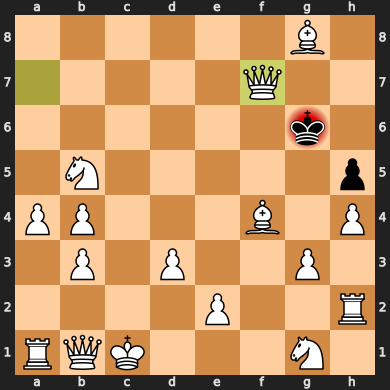

In [1023]:
board = chess.Board()
p1 = RandomPlayer(board, chess.BLACK)
p2 = MinimaxPlayer(board, chess.WHITE, depth=2)
match = ChessMatch(board, p1, p2)
outcome = match.run_match()
print(outcome)
board

# Tournament

In [1024]:
board = chess.Board()
p1 = MinimaxPlayer(board, chess.WHITE, depth=1)
p2 = MinimaxPlayer(board, chess.BLACK, depth=2)
tournament = ChessTournament(board, p1, p2)
tournament.run_tournament(num_matches=2)

White: 0.0%
Black: 100.0%
Draws: 0.0%


# Human vs AI

### Initialization

In [1025]:
board = chess.Board()
AI = MinimaxPlayer(board, chess.BLACK, depth=3)

### Board

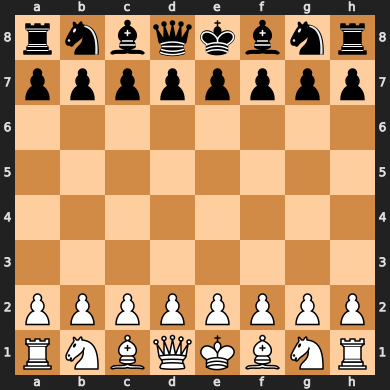

In [1026]:
if board.is_game_over():
    print(f'Outcome: {outcome}')
board

### Human move

In [1027]:
move = 'e2e3'

move = chess.Move.from_uci(move)
if move not in board.legal_moves:
    print(f'{move} is not a legal move')
else:
    board.push(move)

### AI move

In [1028]:
move = AI.choose_move()
print(f'Chosen move: {move}')
board.push(move)

Chosen move: g8h6
